# Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf

# Append source directory to path
sys.path.append("../../src/")

# Import custom modules
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import load_zip_train_test_data
from model_functions import make_gravnet_model
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback, CyclicalLearningRate, LossPlotCallback
from helper_functions import create_output_directory, create_gif_from_pngs

# Load Data

In [2]:
batch_size = 16         # Batch size

project_directory = '../../projects/antarctica.09.17.2024.12.42/training/'
#project_directory = '../../projects/nightly.08.28.2024.21.04/training/'
(train_X, train_y, train_misc), (test_X, test_y, test_misc), train_size, test_size = load_zip_train_test_data(project_directory, batch_size=batch_size)

# Zip the training and testing datasets so that they can be used in model.fit()
train_data = tf.data.Dataset.zip((train_X, train_y))
test_data = tf.data.Dataset.zip((test_X, test_y))

# GravNet Model

In [14]:
# Set training parameters
initial_lr = 1e-6       # Initial learning rate for CLR
max_lr = 1e-5           # Maximum learning rate for CLR
step_size = 20          # 20 batches for half cycle, so 40 batches for a full cycle
N_epochs = 10           # Number of epochs to train
q_min = 0.1             # q_min for the custom loss
tB = 0.1                # Minimum beta for clustering
tD = 0.25               # Minimum distance for clustering
ev_n = 10               # Event numbers to plot

# Produce new output directory for saving plots
outdir = create_output_directory("./out")

# Define the model
model = make_gravnet_model(
    K=100,
    N_feat=30,
    N_grav_layers=2,
    N_neighbors=10,
    N_filters=64
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Instantiate the custom loss function
custom_loss = CustomLoss(q_min=q_min)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=[
        AttractiveLossMetric(q_min=q_min),
        RepulsiveLossMetric(q_min=q_min),
        CowardLossMetric(q_min=q_min),
        NoiseLossMetric(q_min=q_min)
    ]
)

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

clr_callback = CyclicalLearningRate(
    initial_learning_rate=initial_lr, 
    max_learning_rate=max_lr, 
    step_size=step_size
)

for x in train_X.take(1):
    ecal_x = x[0:0+ev_n]
    break
for y in train_y.take(1):
    ecal_y = y[0:0+ev_n]
    break
for misc in train_misc.take(1):
    ecal_misc = misc[0:0+ev_n]
    break

ecal_plot_callback = PlotCallback(
    X=ecal_x,
    y=ecal_y,
    misc=ecal_misc,
    tB=tB,
    tD=tD,
    outdir=outdir
)

loss_plot_callback = LossPlotCallback(
    save_dir=outdir
)

# Output the number of parameters in the model
print("Number of Parameters:", model.count_params())

Number of Parameters: 35643


In [15]:
# Train the model
history = model.fit(train_data,
                    batch_size=batch_size,
                    epochs=10,
                    shuffle=True,
                    #validation_data=test_data,
                    #steps_per_epoch=305,
                    #steps_per_epoch=int(train_size/batch_size),
                    callbacks=[#early_stopping_callback,
                               #clr_callback,
                               #ecal_plot_callback,
                               #loss_plot_callback
                    ])

Epoch 1/10
4/4 [==============================] - 9s 32ms/step - loss: 11.1923 - attractive_loss: 10.4447 - repulsive_loss: 0.0249 - coward_loss: 0.2165 - noise_loss: 0.5061
Epoch 2/10
4/4 [==============================] - 0s 18ms/step - loss: 10.9361 - attractive_loss: 10.1866 - repulsive_loss: 0.0241 - coward_loss: 0.2192 - noise_loss: 0.5062
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 11.7192 - attractive_loss: 10.9582 - repulsive_loss: 0.0265 - coward_loss: 0.2266 - noise_loss: 0.5080
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 9.6948 - attractive_loss: 8.9320 - repulsive_loss: 0.0242 - coward_loss: 0.2290 - noise_loss: 0.5097
Epoch 5/10
4/4 [==============================] - 0s 17ms/step - loss: 9.1621 - attractive_loss: 8.4068 - repulsive_loss: 0.0261 - coward_loss: 0.2204 - noise_loss: 0.5089
Epoch 6/10
4/4 [==============================] - 0s 18ms/step - loss: 9.9013 - attractive_loss: 9.1431 - repulsive_loss: 0.0245 - cow

In [16]:
# Define the path to save the model
model_save_path = f"{outdir}/trained_model"

# Save the model
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")

INFO:tensorflow:Assets written to: ./out/09_18_2024_0022/trained_model/assets


INFO:tensorflow:Assets written to: ./out/09_18_2024_0022/trained_model/assets


Model saved at: ./out/09_18_2024_0022/trained_model


In [9]:
# Define the path to load the model from
#model_load_path = f"{outdir}/trained_model"
model_load_path = "./out/09_18_2024_0022/trained_model"
# Load the model
model = tf.keras.models.load_model(model_load_path, custom_objects={
    'CustomLoss': CustomLoss, 
    'AttractiveLossMetric': AttractiveLossMetric,
    'RepulsiveLossMetric': RepulsiveLossMetric,
    'CowardLossMetric': CowardLossMetric,
    'NoiseLossMetric': NoiseLossMetric
})
evaluator = Evaluator('../../projects/antarctica.09.17.2024.12.42/training/dataset_train.h5', Nevents=100)
#evaluator = Evaluator('../../projects/rfeel.09.18.2024.10.51/training/dataset_train.h5', Nevents=100)
evaluator.load_model(model)
evaluator.predict()
evaluator.cluster(0.2,0.42)

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

Randomly generated event number = 23


array([<Axes: xlabel='ECAL::hits (X)', ylabel='ECAL::hits (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='ECAL::hits (X)', ylabel='ECAL::hits (Y)'>,
       <Axes: xlabel='ECAL::hits (X)', ylabel='ECAL::hits (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='Learned $\\beta$'>], dtype=object)

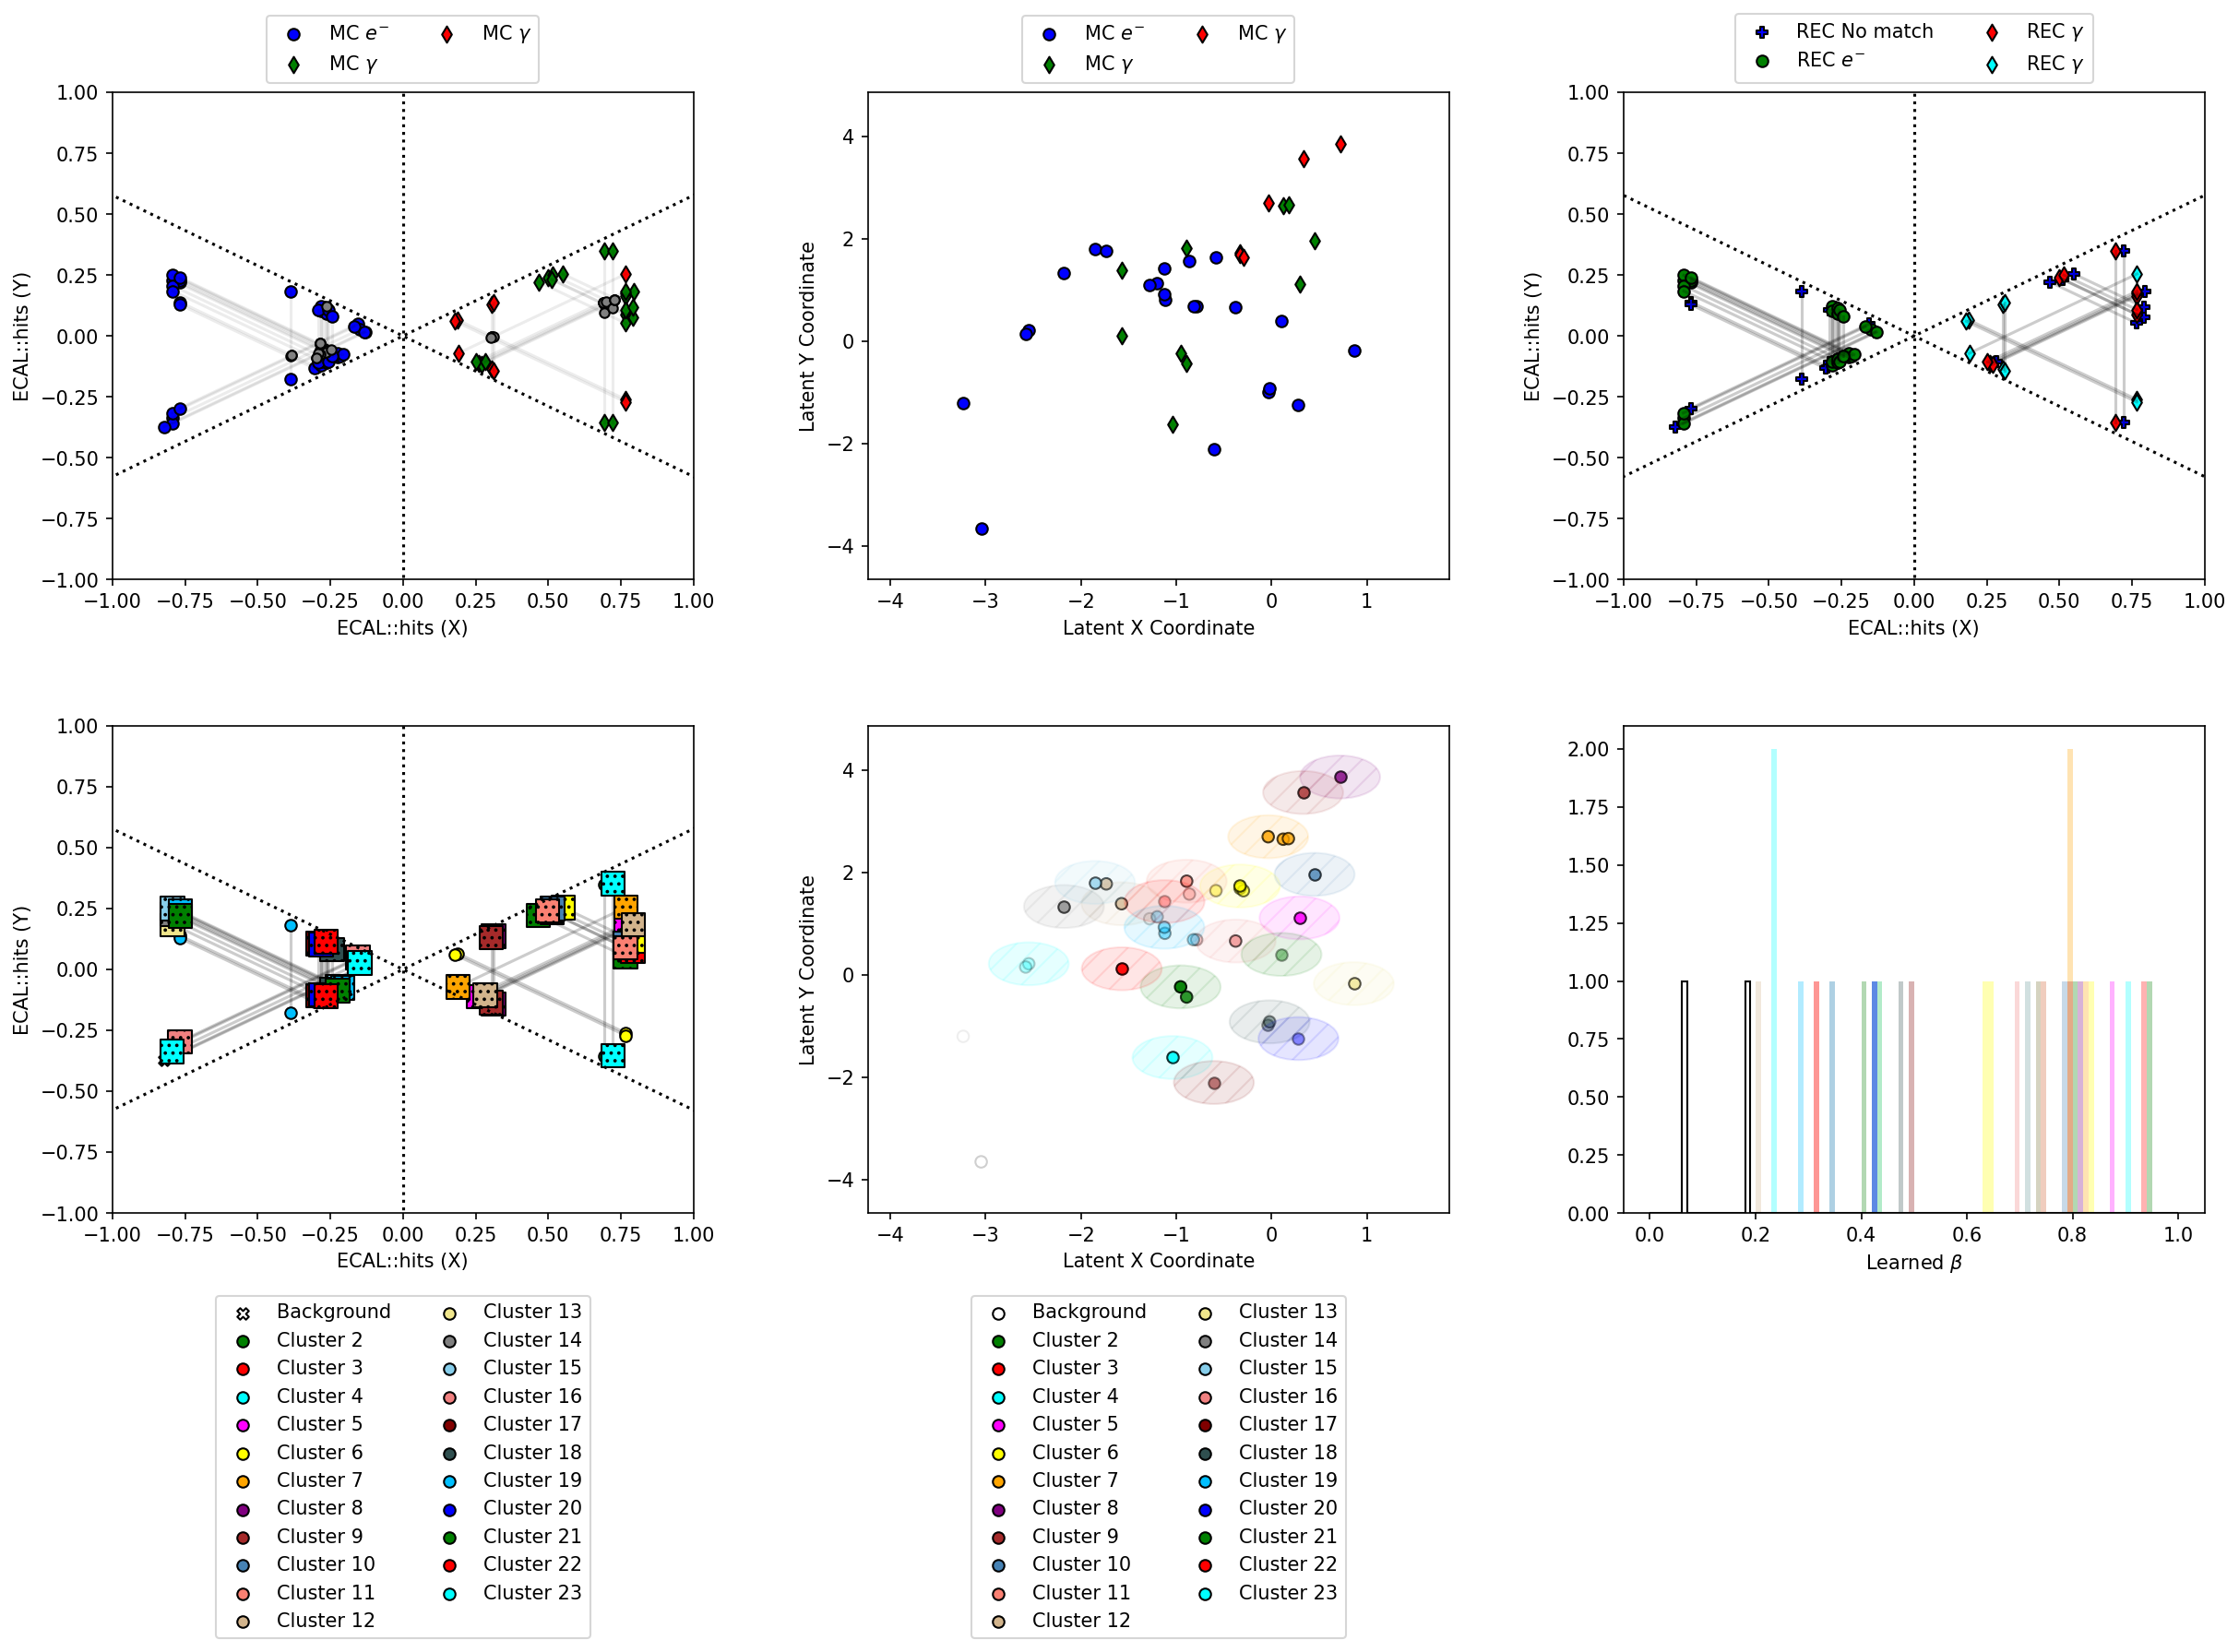

In [4]:
plotter = ModelEcalPlotter(evaluator.get_event_dataframe())
plotter.plot_all(tD=evaluator.tD)

In [8]:
evaluator.to_cluster_dataframe()

,event,id,mc_pid,otid,sector,layer,energy,time,xo,yo,...,ze,rec_pid,pindex,centroid_x,centroid_y,centroid_z,is_3way_same_group,is_2way_same_group,is_3way_cross_group,is_2way_cross_group
0,0,0,-211.0,3.0,2,7,0.04531,154.516251,264.973389,-121.441513,...,721.147766,-211.0,2.0,263.565674,77.861206,721.147766,1.0,0.0,0.0,0.0
2,0,0,2212.0,1.0,5,7,0.02908,164.247650,-364.741943,176.572144,...,674.624878,211.0,0.0,-366.774170,-95.636292,674.624878,1.0,0.0,0.0,0.0
3,0,0,2212.0,1.0,5,5,0.01874,161.104965,-285.649170,-133.385498,...,640.867859,211.0,0.0,-354.210571,-92.404556,659.963867,1.0,0.0,0.0,0.0
4,0,0,2212.0,1.0,5,4,0.01423,163.044296,-352.232178,170.580261,...,659.966919,211.0,0.0,-352.232178,-154.562622,659.966919,1.0,1.0,0.0,0.0
8,0,0,2212.0,1.0,5,8,0.01156,161.927322,-295.797607,-138.042969,...,654.820129,211.0,0.0,-366.774170,-95.636292,674.584595,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,77,0,2112.0,356.0,1,6,0.00137,167.860657,344.104309,-259.726807,...,792.316040,2112.0,3.0,173.596985,-160.756607,721.866333,1.0,0.0,0.0,0.0
7751,77,0,22.0,359.0,3,6,0.00124,152.878738,51.733032,427.135559,...,792.878052,-1.0,-1.0,48.872742,117.143860,768.246094,0.0,1.0,0.0,0.0
7752,77,0,-211.0,357.0,1,8,0.00111,181.922699,89.447815,-82.978531,...,654.853943,-1.0,-1.0,89.607361,-100.275085,784.686157,0.0,1.0,0.0,0.0
7753,77,0,22.0,359.0,3,7,0.00109,151.812729,79.298035,75.688171,...,795.652710,-1.0,-1.0,30.835571,102.290405,795.652710,0.0,0.0,1.0,0.0


In [6]:
df = evaluator.dataframe.copy()
df.rename(columns={'event': 'event_number',
                   'unique_otid': 'otid'})

,event_number,energy,time,xo,yo,zo,xe,ye,ze,sector,...,is_2way_cross_group,rec_pid,pindex,mc_pid,otid,beta,xc,yc,cluster_id,is_cluster_leader
0,0,0.147937,0.131879,0.529947,-0.242883,721.147766,0.529947,0.239875,721.147766,2,...,0.0,-211.0,2.0,-211.0,3.0,0.470512,0.239344,-0.336947,18,1
1,0,0.123902,0.289479,0.451394,0.195340,740.828613,0.819416,-0.012634,655.022949,2,...,0.0,-211.0,2.0,-211.0,3.0,0.847987,-0.985718,-0.190605,5,1
2,0,0.093982,0.322436,-0.729484,0.353144,674.624878,-0.729484,-0.354152,674.624878,5,...,0.0,211.0,0.0,2212.0,1.0,0.218726,-0.832738,-0.301150,5,0
3,0,0.059607,0.260897,-0.571298,-0.266771,692.381165,-0.792239,-0.141914,640.867859,5,...,0.0,211.0,0.0,2212.0,1.0,0.561933,-1.416974,-0.657069,16,1
4,0,0.044614,0.298872,-0.704464,0.341161,659.966919,-0.704464,-0.342169,659.966919,5,...,0.0,211.0,0.0,2212.0,1.0,0.532590,-3.841489,-3.048547,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7752,77,0.000997,0.668543,0.178896,-0.165957,791.708252,0.185116,-0.840140,654.853943,1,...,0.0,-1.0,-1.0,-211.0,357.0,0.383770,-4.178354,-3.695323,30,1
7753,77,0.000931,0.078940,0.158596,0.151376,795.652710,0.051645,0.213124,795.652710,3,...,0.0,-1.0,-1.0,22.0,359.0,0.698265,2.035427,2.418049,19,1
7754,77,0.000864,0.320521,0.692875,-0.549145,655.784058,0.051757,-0.171065,806.864319,1,...,0.0,-1.0,-1.0,2112.0,356.0,0.736492,-3.984510,-1.841322,16,1
7755,77,0.000798,0.223733,0.821286,0.392928,655.953125,0.113318,-0.007153,821.018433,2,...,0.0,-1.0,-1.0,-211.0,357.0,0.615871,-2.878467,-1.216901,22,1
